# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [2]:
# !pip install palmerpenguins
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from palmerpenguins import load_penguins
from plotnine import ggplot, aes, geom_line, geom_point, labs

In [3]:
penguins = load_penguins()
penguins = penguins.dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [4]:
# dummify
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

#ct.fit_transform(penguins)

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [5]:
X = penguins.drop(["bill_depth_mm"], axis = 1)
y = penguins["bill_depth_mm"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# multiple linear regression
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

lr_pipeline.fit(X_train, y_train)

# Predictions
lr_train_pred = lr_pipeline.predict(X_train)
lr_test_pred = lr_pipeline.predict(X_test)

# Compute training and test errors
lr_train_error = mean_squared_error(y_train, lr_train_pred)
lr_test_error = mean_squared_error(y_test, lr_test_pred)

print(f"Linear Regression - Training Error: {lr_train_error:.3f}, Test Error: {lr_test_error:.3f}")

Linear Regression - Training Error: 0.536, Test Error: 0.813


In [6]:
# kNN model with k=1
k1_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsRegressor(n_neighbors=1))
])

k1_pipeline.fit(X_train, y_train)

# Predictions
k1_train_pred = k1_pipeline.predict(X_train)
k1_test_pred = k1_pipeline.predict(X_test)

# Compute training and test errors
k1_train_error = mean_squared_error(y_train, k1_train_pred)
k1_test_error = mean_squared_error(y_test, k1_test_pred)


print(f"kNN(k=1) Regression - Training Error: {k1_train_error:.3f}, Test Error: {k1_test_error:.3f}")

kNN(k=1) Regression - Training Error: 0.000, Test Error: 1.030


In [7]:
k10_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn", KNeighborsRegressor(n_neighbors=100))
])

k10_pipeline.fit(X_train, y_train)

# Predictions
k10_train_pred = k10_pipeline.predict(X_train)
k10_test_pred = k10_pipeline.predict(X_test)

# Compute training and test errors
k10_train_error = mean_squared_error(y_train, k10_train_pred)
k10_test_error = mean_squared_error(y_test, k10_test_pred)


print(f"kNN(k=10) Regression - Training Error: {k10_train_error:.3f}, Test Error: {k10_test_error:.3f}")

kNN(k=10) Regression - Training Error: 1.548, Test Error: 1.935


In [8]:
dt_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeRegressor(max_depth = 3))
])

dt_pipeline.fit(X_train, y_train)

# Predictions
dt_train_pred = dt_pipeline.predict(X_train)
dt_test_pred = dt_pipeline.predict(X_test)

# Compute training and test errors
dt_train_error = mean_squared_error(y_train, dt_train_pred)
dt_test_error = mean_squared_error(y_test, dt_test_pred)


print(f"Decision Tree Regression - Training Error: {dt_train_error:.3f}, Test Error: {dt_test_error:.3f}")

Decision Tree Regression - Training Error: 0.520, Test Error: 0.824


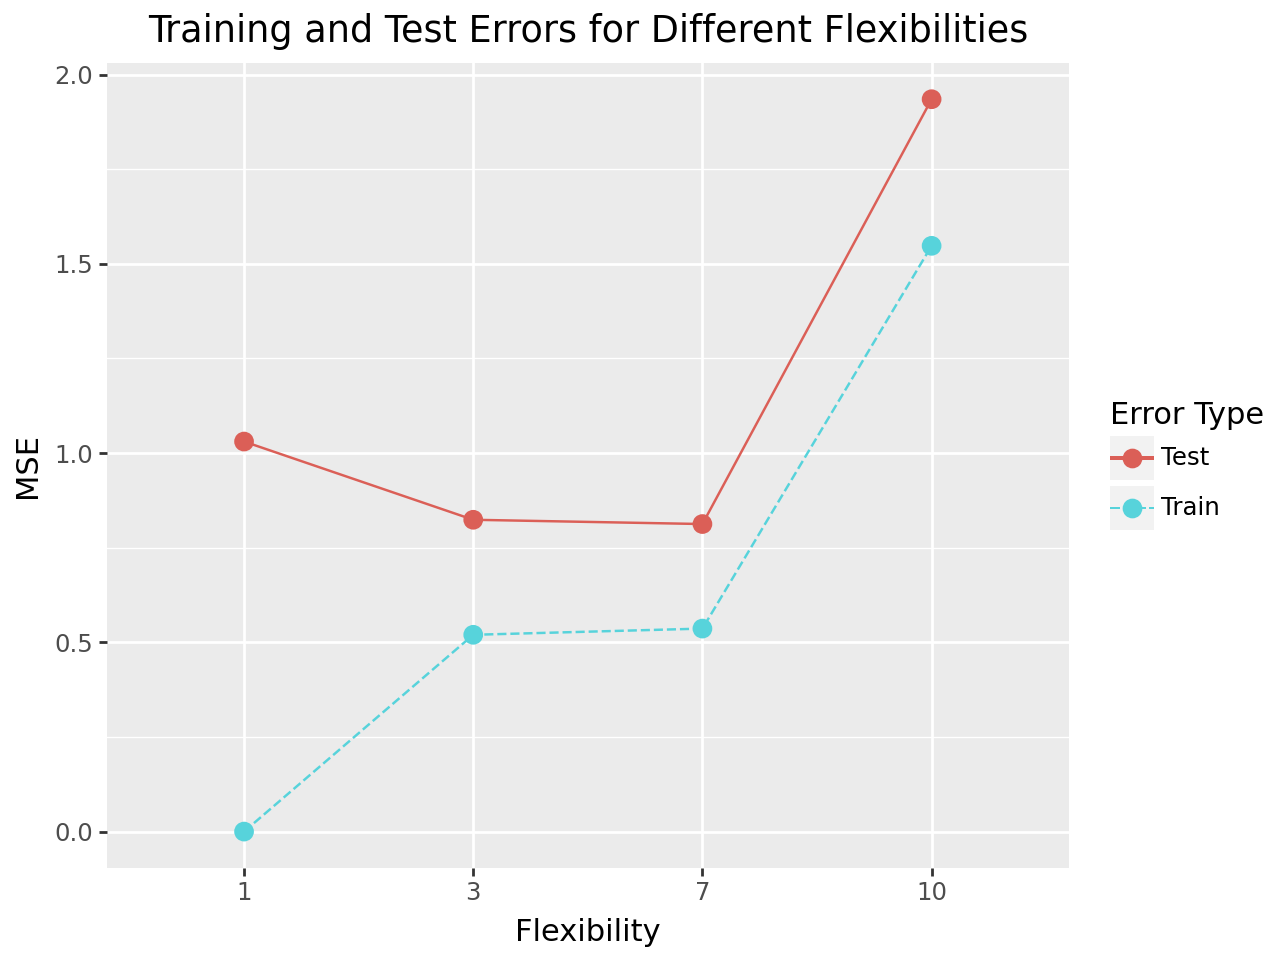

In [19]:
data = {
    'Model': ['kNN (k=1)', 'Decision Tree', 'Linear Regression', 'kNN (k=10)',
              'kNN (k=1)', 'Decision Tree', 'Linear Regression', 'kNN (k=10)'],
    'Flexibility' : ['1', '3', '7', '10', '1', '3', '7', '10'],
    'Error_Type': ['Train', 'Train', 'Train', 'Train',
                   'Test', 'Test', 'Test', 'Test'],
    'Error_Value': [
        k1_train_error, dt_train_error, lr_train_error, k10_train_error,
        k1_test_error, dt_test_error, lr_test_error, k10_test_error
    ]
}
df = pd.DataFrame(data)
df['Flexibility'] = pd.Categorical(df['Flexibility'], categories=['1', '3', '7', '10'], ordered=True)

plot = (
    ggplot(df, aes(x='Flexibility', y='Error_Value', color='Error_Type', group='Error_Type')) +
    geom_line(aes(linetype='Error_Type')) +
    geom_point(size=3) +
    labs(title="Training and Test Errors for Different Flexibilities",
         x="Flexibility",
         y="MSE",
         color="Error Type",
         linetype="Error Type")
)

plot

### Conclusion
Linear regression model (Flexibility = 7) seems to be the best model because it has the lowest test error and the train and test error are the closest